# Explainer notebook - Songwriter, artists and song project

------------------------------------

# Motivation

#### What is your dataset?
Our dataset contains the top 50 songs from the top artists of the decade of 2010. Based on the top 100 list of artists from pulse music, we fetched the top 50 songs for each of the 100 artists. We have then expanded the dataset by adding select features such as all featuring artists of the songs, the
release year, the duration of the song, popularity score from Spotify, all songwriters listed on the song and lastly each song’s lyrics. We constructed the dataset ourself by using multiple different API’s - specifically the Genius API, Spotify API and Musicbrainz API.½

#### Why did you choose this/these particular datasets?

We wanted to research what the connection between present day artists or songs was by looking at how the artists and songs might be connected by common songwriters or lyrics. We wanted to expand this research by both looking at what connection this might have to the popularity of the song and how the themes in the lyrics might be influenced or depend on the songwriters and how these themses vary and change depending on the release year. 

We decided to use a list of the top 100 artists from pulse music in order to narrow down the artists to look at. Here our thought process was that the artists with the most means and oppertunities would be the ones the most popular and the ones appearing in the top 50. These artists would have the most ressources to bring in the best songwriters which could possibly create a network behind the scenes of the music industry with these songwriters being the mastermind of the most famous artists. 

Through Genius we could fetch lyrics for all the songs, from musicBrainz we got all the songwriters and from spotify we could fetch the remaining attributes we have included.

#### What was your goal for the end user's experience?

We had both heard a bit here and there on the internet and through other people that a lot of popular artists do not write their own songs and that many popular songs share common songwriters. It made us curious to actually map out how music industry was structured behind the scenes of the most popular artists that we are presented with on the stage and in the radio. The main goal has been to give the end user an engaging and insightful exploration of the music landscape by uncovering the hidden connections between artists, songwriters and songs. To achieve this we have focused in on 2 different areas:

1. Highlighting songwriters, how they are used by different artists and the difference here between top artists.
2. Determining popular themes and trends in songs and whether they depend on the songwriter


 On the surface it might not be clear which artists are actual central nodes and which artist or songwriters have the most influence. Here, we try to highlight the most influential songwriters who play a significant role behind the scenes. We aimed to visualize how some artists are also interlinked through shared songwriters, enabling users to discover collaborative patterns and creative networks. We aimed to identify and map potential communities within the artist and song networks connected by songwriters and thereby offering users a broader understanding of the structure and dynamics of the music industry. By including popularity we also had a way of defining succes in these communities. The dataset and network enabled us to compare of how the different top artists utilize songwriters, possibly revealing strategic or stylistic differences.

For the second goal we include the lyrics of the songs in order for us to do semantic analysis to uncover thematic patterns to add to the end user's experience. By analyzing lyrics based on their release year and popularity levels, we aimed to reveal how themes evolve and what actually resonates with the audience — such as shifting from love and heartbreak to empowerment or social commentary. This allows users to explore how artists and songwriters reflect cultural changes through language. With the lyrics we provide insights into what recurring motifs, emotional tone, and general language trends are present in the lyrics. Ultimately, the goal was to let users interact with the lyrical content on a deeper level. 

---------------------------------

# Basic Stats

Packages

In [43]:
#GENERAL
import pandas as pd
import numpy as np
import requests
import time
from tqdm import tqdm
from ratelimit import limits, sleep_and_retry
from bs4 import BeautifulSoup
import unicodedata
import builtins
import ast
import matplotlib.pyplot as plt
import seaborn as sns

#SPOTIFY
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException

#MUSIC BRAINZ
import musicbrainzngs

#GENIUS
import lyricsgenius
import re

#TOKENIZE
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

#LYRICS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

#NEEDED
import warnings


## Constructing dataset

When we constructed the dataset we did through multiple rounds. First we fetched the top 50 songs for each of the top 100 artists but to no risk loosing data if the process for some reason was interrupted we split the 100 artists into 2 and after each round we saved it as a csv. We then for each of these csv files first fecthed all lyrics and saved those as seperate dataframes and also for the songwriters, which were also saved as seperate csv files. At the end when we had collected all the data for all songs, we combined the multiple csv files into one dataset which is saved as final_dataset.csv. 

##### Fetch top 50 songs from top 100 artists with Spotify API

In [2]:
# Safe retry function
def safe_spotify_call(call_func, *args, sleep=0.4, **kwargs):
    time.sleep(sleep)
    
    try:
        return call_func(*args, **kwargs)
    
    #Depending on the type of spotify API error retry
    except SpotifyException as e:
        # Error "Too Many Requests"
        if e.http_status == 429:
            retry_after = int(e.headers.get("Retry-After", 10))
            print(f"Rate limit hit. Sleeping for {retry_after} seconds...")
            time.sleep(retry_after + 1)
            return safe_spotify_call(call_func, *args, **kwargs)
        else:
            print(f"Spotify error: {e}")
            return None

    #network error
    except requests.exceptions.RequestException as e:
        print(f" Network error: {e}")
        time.sleep(5)
        return safe_spotify_call(call_func, *args, **kwargs)


In [ ]:
def get_top_50_songs_by_artist(artist_query, market="US"):
    #SPOTIFY API credentials 
    SPOTIFY_CLIENT_ID = "449143cf15fe468e94f3c16d7a51c17f"
    SPOTIFY_CLIENT_SECRET = "60259a57c2f14c5190a68381fa4bb013"
    
    #Use credentials
    auth_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET)
    spotify = spotipy.Spotify(auth_manager=auth_manager)

    #Get artist based on ID
    if len(artist_query) == 22 and " " not in artist_query:
        artist_id = artist_query
        artist_info = safe_spotify_call(spotify.artist, artist_id)
        artist_name = artist_info["name"]

    #Get artist based on name
    else:
        result = safe_spotify_call(spotify.search, q=f"artist:{artist_query}", type="artist", limit=5)

        #No artist match
        if not result['artists']['items']:
            print(f"No artist found for query: {artist_query}")
            return pd.DataFrame()
        
        #Select most popular match
        best_match = max(result['artists']['items'], key=lambda x: x['popularity'])
        artist_id = best_match['id']
        artist_name = best_match['name']

    #Get all albums from artist
    album_result = safe_spotify_call(spotify.artist_albums, artist_id, album_type='album,single,compilation', limit=50)
    albums = album_result.get('items', [])
    album_ids = list({album['id'] for album in albums})

    #Step 3 :Get all tracks from artist
    track_info = {}
    for album_id in album_ids:
        try:
            album = safe_spotify_call(spotify.album, album_id)
            if not album:
                continue
            release_year = album.get("release_date", "1900").split("-")[0]
            tracks = safe_spotify_call(spotify.album_tracks, album_id)
            if not tracks:
                continue
            for track in tracks['items']:
                track_id = track['id']
                track_name = track['name']
                track_artists = [a['name'] for a in track['artists']]
                artist_names = ", ".join(track_artists)

                if artist_name.lower() not in [a.lower() for a in track_artists]:
                    continue

                if track_name not in track_info:
                    track_info[track_name] = {
                        'id': track_id,
                        'name': track_name,
                        'artists': artist_names,
                        'release_year': release_year
                    }
        time.sleep(0.1)

    #Add track popularity and duration
    tracks = list(track_info.values())
    for i in range(0, len(tracks), 50):
        batch = tracks[i:i + 50]
        ids = [t['id'] for t in batch]
        full_tracks = safe_spotify_call(spotify.tracks, ids)
        if full_tracks:
            for t, ft in zip(batch, full_tracks['tracks']):
                t['popularity'] = ft['popularity']
                t['duration_ms'] = ft['duration_ms']
        time.sleep(0.2) 

    #Return top 50 by popularity
    df = pd.DataFrame(tracks)
    if df.empty:
        return df
    df = df.sort_values(by="popularity", ascending=False).head(50)
    return df[['name', 'artists', 'popularity', 'duration_ms', 'release_year']]

In [ ]:
#List of artists
top_50_artists_2010 = [
    "Drake", "Taylor Swift", "Bruno Mars", "Rihanna", "4dpARuHxo51G3z768sgnrY",
    "Ed Sheeran", "Justin Bieber", "Katy Perry", "Maroon 5",
    "Post Malone", "Lady Gaga", "Ariana Grande", "Imagine Dragons", "Nicki Minaj","Eminem","Luke Bryan","Pink","One Direction","Justin Timberlake",
    "Kendrick Lamar","Lady Antebellum","Beyonce","Jason Aldean","Sam Smith","Kesha","Flordia Georgia Line","Twenty one pilots","Lil Wayne","Chris Brown",
    "Blake Shelton","Travis Scott","Khalid","Shawn Mendes","Cardi B","Future","Mumford & sons","Selena Gomez","Jay-Z","Meghan Trainor","J. Cole","Usher",
    "Coldplay","The Black Eyed Peas","Pitbull","Flo Rida","Michael Buble","Zac Brown Band","Jason Derulo"
]

top_50_100_artists_2010 = [
    "The chainsmokers","Halsey","Lorde","Kanye West","Kenny Chesney","Miley cyrus","Carrie Underwood","Wiz Khalifa","Migos","Kelly Clarkson","OneRepublic",
    "Macklemore & Ryan Lewis","XXXtentacion","Eric Church","Juice Wrld","fun.","Billie Ellish","LMFAO","DJ khaled","Chris stapleton","Calvin harris","Britney spears",
    "Fetty wap","Sia","Pentatonix","David Guetta","U2","Ellie Goulding", "The lumineers","Pharrell Williams","The rolling stones","Train","Trey songz",
    "Demi lovato","Sam hunt","Big sean","Camila cabello","lil uzi vert","Panic! at the disco","Miranda lambert","Bruce springsteen","John legend","B.o.B",
    "21 savage","Thomas Rhett","Meek mill","Keith Urban","Bon jovi","5 seconds of summer","paul mccartney"
]

# Empty dictionary to store results
artist_song_dfs = {}

# Loop over each artist and fetch top 50 songs
for artist in top_50_artists_2010:
    df = get_top_50_songs_by_artist(artist)
    artist_song_dfs[artist] = df

In [ ]:
# Merge all artist dataFrames
all_songs_df = pd.concat(artist_song_dfs.values(), keys=artist_song_dfs.keys(), names=["Artist"])

#Reset index
all_songs_df = all_songs_df.reset_index(level="Artist").reset_index(drop=True)

#Drop NaN
all_songs_df.dropna()

In [ ]:
all_songs_df.to_csv('first_50_artists.csv', index=False)

#### Fetch songwriters for each song with MusicBrainz API

We saved the dataframe from the previous fetching as a cvs to ensure we did not loose data. We then loaded this in to add the songwriters for each song. 

In [ ]:
# Rate limit - 1 call per second
CALLS = 1
PERIOD = 1 

@sleep_and_retry
@limits(calls=CALLS, period=PERIOD)

#Safe function to search works
def safe_search_works(title, artist):
    return musicbrainzngs.search_works(query=title, artist=artist, limit=1)

@sleep_and_retry
@limits(calls=CALLS, period=PERIOD)

#Safe function to get work
def safe_get_work_by_id(work_id):
    return musicbrainzngs.get_work_by_id(work_id, includes=["artist-rels"])

#Safe function to get songwriters
def get_songwriters_from_musicbrainz(title, artist):
    writers = []

    try:
        work_result = safe_search_works(title, artist)
        if work_result['work-list']:
            work_id = work_result['work-list'][0]['id']
            work_data = safe_get_work_by_id(work_id)
            for rel in work_data['work'].get("artist-relation-list", []):
                if rel['type'] in ["composer", "lyricist", "writer"]:
                    writers.append(rel['artist']['name'])
    except Exception as e:
        print(f"[MusicBrainz Writers Error] {title} - {artist}: {e}")

    return ", ".join(writers)

In [ ]:
#Load dataset with songs from SPOTIFY fetch
all_songs = pd.read_csv("first_50_artists.csv")

In [ ]:
#Break all_songs dataframe into smaller batches
all_songs = all_songs[:1000]
all_songs

In [ ]:
#Fecth songwriters for all songs
tqdm.pandas()
all_songs["songwriters"] = all_songs.progress_apply(lambda row: get_songwriters_from_musicbrainz(row["name"], row["Artist"]), axis=1)

In [ ]:
all_songs.to_csv('first_50_artists_with_songwriters.csv', index=False)

#### Fetch lyrics for each song with GENIUS API

Again here, we saved the dataframe from the previous fetching as a cvs to ensure we did not loose data. We then loaded this in to add the lyrics for each song. 

In [ ]:
# Genius API setup
genius = lyricsgenius.Genius("ZVjXsUV0Xb_wHopoibicTBRVRv8eJvdu4i7NL5mW2hcITfM6W2cvk4ha6kBktTNL", timeout=15)
genius.skip_non_songs = True
genius.excluded_terms = ["(Remix)", "(Live)"]

# Common language names to filter
LANGUAGE_NAMES = {
    "English", "Español", "Français", "Deutsch", "Português", "Русский", "العربية", "日本語", "Türkçe",
    "한국어", "Polski", "Italiano", "Українська", "Tiếng Việt", "Bahasa Indonesia", "Svenska", "Norsk",
    "Ελληνικά", "עברית", "Magyar", "Čeština", "Slovenčina", "Беларуская", "Català", "Македонски", "Српски",
    "ไทย", "Česky", "Română", "हिन्दी"
}

def is_probably_language_line(line):
    return (
        line in LANGUAGE_NAMES or
        (line.isalpha() and line.istitle() and len(line.split()) == 1)
    )

def is_non_latin_text(line):
    return all(
        not unicodedata.name(char, "").startswith("LATIN") 
        for char in line if char.isalpha()
    )

def get_lyrics(song_title, artist_name):
    try:
        original_print = builtins.print
        builtins.print = lambda *args, **kwargs: None

        song = genius.search_song(song_title, artist_name)

        builtins.print = original_print
        if not song:
            return None

        page = requests.get(song.url)
        soup = BeautifulSoup(page.text, "html.parser")

        lyrics_divs = soup.select("div[data-lyrics-container='true']")
        lyrics_lines = []

        for div in lyrics_divs:
            for line in div.stripped_strings:
                line = line.strip()

                if (
                    line.startswith("[") and line.endswith("]") or
                    is_probably_language_line(line) or
                    is_non_latin_text(line) and len(line) < 20 or
                    "translation" in line.lower() or
                    "contributors" in line.lower() or
                    "edit" in line.lower() or
                    line.lower().endswith("lyrics") or
                    "read more" in line.lower() or
                    line.lower().startswith("“") or
                    "is a track that" in line.lower() or
                    "/" in line or "(" in line or ")" in line or
                    line.lower().startswith("concluding ") or
                    line.lower().startswith("this track") or
                    line.lower().startswith("the song") or
                    len(line) < 10 and not any(char.isalpha() for char in line) or
                    line.endswith("…") or "…" in line
                ):
                    continue

                lyrics_lines.append(line)

        return "\n".join(lyrics_lines).strip() if lyrics_lines else None

    except Exception:
        return None


In [ ]:
#Remove anything containing feature in the title
def remove_feat(text):
    return re.sub(r"[\(\[\-]?\s*(feat\.?|ft\.?)\s+[^\)\]]+[\)\]]?", "", text, flags=re.IGNORECASE).strip()

all_songs["name"] = all_songs["name"].apply(remove_feat)


In [ ]:
songs_to_scrape = pd.read_csv("first_50_100_artists.csv")

In [ ]:
tqdm.pandas()

def scrape_with_delay(row):
    lyrics = get_lyrics(row["name"], row["Artist"])
    time.sleep(2)  # Safe delay to prevent rate-limiting
    return lyrics

songs_to_scrape["lyrics"] = songs_to_scrape.progress_apply(scrape_with_delay, axis=1)

In [ ]:
songs_to_scrape.to_csv('first_50_artists_with_lyrics.csv', index=False)


## Data cleaning and preprocessing

In each of the 3 fetching steps we included datacleaning as a way of ensuring the data was clean for the next step. For all 3 steps we removed any rows containing NaN as we only wanted songs which had all features. 

**SPOTIFY API** $\newline$
When fetching the top 50 songs for the top artists we experienced that some artists have shared artistic names, which meant that we were retrieving wrong information. To overcome this we looked up the specific ID for the artists causing problems and used these instead to ensure we fetched the correct artist. 

**GENIUS** $\newline$
The GENIUS API had multiple extra information besides the lyrics when we fetched it such as including languages and descriptive lines for the content. To overcome this we introduced a list of common languages where lines containing these should be removed. Similarly the descriptive lines contained specific enough words that we were able to remove them and single out just the lyrics to add to the dataset. 

**SOURCES OF ERROR:** $\newline$
We discovered during our work with the dataset that some artists names where replaced by other artists such as pink vs pink floyd and aditionally that some artists even though they appeared in the dataset were skipped in the code such as The Black Eyed Peas, U2 and fun. We also realised that we had mistakenly missed two artists "The Weeknd" and "Florida Georgia Line", which was a mistake we did not catch when fetching the dataset. Lastly we also ran had changed some Adele's name to an ID code, but forgot to change it back afterwards, which also lead to her not being included. Due to time restrainst at this point, we could not fetch the data again, and therefore decided to remove the problematic artists and continue without the missing artists. Furthermore in the top 100 list there was a group based around covers for kids, which we also removed from our list of top artists. This is the explanation for the missing artists in the following data stats. 

##### Basic stats for the dataset: 

**SONGS:** 3731 $\newline$
**SONGWRITERS:** 4498 $\newline$
**ARTISTS:** 91 $\newline$


## Lyrics preprocessing and tokenizing

The tokenizing of the dataset works by merging two CSV files, counting unique songs, and preparing the lyrics for text analysis. Before tokenization, the lyrics are cleaned by removing section headers and artist name cues commonly found in formatted lyrics, such as [Chorus], {Bridge}, or (Verse). This is done by dropping any line that begins with a bracket, brace, or parenthesis, ensuring that only the actual lyrical content remains. We then use NLTK to download language resources and define a function to clean and tokenize lyrics by lowercasing, removing stopwords, lemmatizing, and deduplicating words. The processed tokens are added as a new column, reordered for clarity, and saved to a new CSV.

In [26]:
import pandas as pd

# Load dataset
df = pd.read_csv("final_dataset.csv")

# Function to remove lines that look like section headers (e.g., [Chorus], {Bridge}, etc.)
def clean_lyrics_sections(text):
    if pd.isna(text):
        return text
    lines = text.splitlines()
    # Remove any line starting with a bracket/brace (like [Verse], {Chorus}, etc.)
    cleaned_lines = [
        line for line in lines
        if line.strip() and not line.strip().startswith(('[', '{', '('))
    ]
    return "\n".join(cleaned_lines).strip()

# Apply cleaning
df["lyrics"] = df["lyrics"].apply(clean_lyrics_sections)

# Save cleaned lyrics
df.to_csv("final_dataset_cleaned.csv", index=False)


In [28]:
df = pd.read_csv('final_dataset_cleaned.csv')


# download NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  # required for lemmatizer
nltk.download('omw-1.4')  # lemmatizer resource


# stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

# Tokenization + Stopwords + Lemmatization + Deduplication
def clean_tokenize_unique(lyrics):
    if pd.isna(lyrics):
        return []
    tokens = word_tokenize(lyrics)
    tokens = [t.lower() for t in tokens if t.isalpha()]  # remove non-alphabetic tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]  # lemmatize and remove stopwords

    # Remove duplicates
    seen = set()
    unique_tokens = []
    for t in tokens:
        if t not in seen:
            seen.add(t)
            unique_tokens.append(t)
    return unique_tokens

# Apply cleaned tokenization
df['tokens'] = df['lyrics'].apply(clean_tokenize_unique)



# Reorder columns so tokens come before lyrics, beacuse we dont want them as the last thing
lyrics_index = df.columns.get_loc('lyrics')
cols = list(df.columns)
cols.insert(lyrics_index, cols.pop(cols.index('tokens')))
df = df[cols]

# save
df.to_csv('final_dataset_tokens.csv', index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claralouisebrodt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claralouisebrodt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/claralouisebrodt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/claralouisebrodt/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Dataset stats 

This ended up being our final dataset. Artist is the main artist, name is the song name, artists are the featuring artists, popularity is a score from SPOTIFY and songwriters contains both componist, lyricist and writer: 


In [29]:
df = pd.read_csv("final_dataset_tokens.csv")
df

,Artist,name,artists,popularity,duration_ms,release_year,songwriters,tokens,lyrics
0,the chainsmokers,Something Just Like This,"['the chainsmokers', 'coldplay']",90.0,247160.0,2017,"['jonny buckland', 'will champion', 'chris mar...","['reading', 'book', 'old', 'legend', 'myth', '...","I've been reading books of old, the legends an..."
1,the chainsmokers,Paris,['the chainsmokers'],82.0,221506.0,2017,['elijah the alchemist'],"['stayin', 'paris', 'get', 'away', 'parent', '...",We were stayin' in Paris\nTo get away from you...
2,the chainsmokers,This Feeling,"['the chainsmokers', 'kelsea ballerini']",74.0,197946.0,2018,"['travis barker', 'tom delonge', 'mark hoppus']","['tell', 'story', 'lay', 'reason', 'say', 'nee...",I'll tell you a story before it tells itself\n...
3,the chainsmokers,Jungle,"['alok', 'the chainsmokers', 'mae stephens']",74.0,175500.0,2023,"['the motels', 'the motels']","['feeling', 'lonely', 'scared', 'letting', 'ke...","I'm out, feeling lonely again\nAm I too scared..."
4,the chainsmokers,Who Do You Love,"['the chainsmokers', '5 seconds of summer']",70.0,226733.0,2019,['the escape club'],"['found', 'cigarette', 'fendi', 'coat', 'even'...",Found cigarettes in your Fendi coat\nEven thou...
...,...,...,...,...,...,...,...,...,...
3726,kendrick lamar,Purple Hearts,"['kendrick lamar', 'summer walker', 'ghostface...",67.0,329295.0,2022,"['westside boogie', 'sam dew', 'ghostface kill...","['mmm', 'hmm', 'rollin', 'seven', 'ai', 'bred'...","Mmm, tippy-toeing and I'm mud-walkin', hmm\nRo..."
3727,kendrick lamar,Swimming Pools (Drank) - Extended Version,['kendrick lamar'],67.0,313786.0,2012,"['kendrick lamar', 'nikhil seetharam', 't‐minus']","['done', 'grew', 'round', 'people', 'livin', '...","Now, I done grew up round some people\nLivin' ..."
3728,kendrick lamar,How Much A Dollar Cost,"['kendrick lamar', 'james fauntleroy', 'ronald...",66.0,261746.0,2015,"['james fauntleroy', 'ronald isley', 'kendrick...","['much', 'dollar', 'really', 'cost', 'question...",How much a dollar really cost?\nThe question i...
3729,kendrick lamar,Hol' Up,['kendrick lamar'],66.0,173158.0,2011,"['kendrick lamar', 'sounwave']","['wrote', 'record', 'thirty', 'thousand', 'foo...",I wrote this record while thirty thousand feet...


In [30]:
def safe_parse(value):
    try:
        parsed = ast.literal_eval(value)
        return parsed if isinstance(parsed, list) else [parsed]
    except:
        return [value]


df['songwriters'] = df['songwriters'].apply(safe_parse)
df = df.explode('songwriters').reset_index(drop=True)

In [31]:
df["Artist"].value_counts()

Artist
coldplay              284
travis scott          282
meghan trainor        263
beyonce               261
kendrick lamar        260
                     ... 
b.o.b                  70
the rolling stones     58
bruce springsteen      51
paul mccartney         28
chris stapleton        20
Name: count, Length: 91, dtype: int64

In [32]:
df["songwriters"].value_counts()

songwriters
max martin         106
meghan trainor      72
benny blanco        70
jay‐z               68
louis bell          66
                  ... 
siobhán donaghy      1
felix howard         1
john lipsey          1
cameron mcvey        1
rob moose            1
Name: count, Length: 4564, dtype: int64

----------------------------

# Tools, theory and analysis

Packages

In [5]:
import pandas as pd
from itertools import combinations
from collections import Counter
import ast
import unicodedata
import networkx as nx
import statistics
import json
from networkx.readwrite import json_graph
import netwulf



##### Describe the process of theory to insight

#### How did you use the tools to understand your dataset?

## **Networks creation and analysis**

#### **Songwriter and artist network**

#### Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

In [33]:
df = pd.read_csv("final_dataset_tokens.csv")
df

,Artist,name,artists,popularity,duration_ms,release_year,songwriters,tokens,lyrics
0,the chainsmokers,Something Just Like This,"['the chainsmokers', 'coldplay']",90.0,247160.0,2017,"['jonny buckland', 'will champion', 'chris mar...","['reading', 'book', 'old', 'legend', 'myth', '...","I've been reading books of old, the legends an..."
1,the chainsmokers,Paris,['the chainsmokers'],82.0,221506.0,2017,['elijah the alchemist'],"['stayin', 'paris', 'get', 'away', 'parent', '...",We were stayin' in Paris\nTo get away from you...
2,the chainsmokers,This Feeling,"['the chainsmokers', 'kelsea ballerini']",74.0,197946.0,2018,"['travis barker', 'tom delonge', 'mark hoppus']","['tell', 'story', 'lay', 'reason', 'say', 'nee...",I'll tell you a story before it tells itself\n...
3,the chainsmokers,Jungle,"['alok', 'the chainsmokers', 'mae stephens']",74.0,175500.0,2023,"['the motels', 'the motels']","['feeling', 'lonely', 'scared', 'letting', 'ke...","I'm out, feeling lonely again\nAm I too scared..."
4,the chainsmokers,Who Do You Love,"['the chainsmokers', '5 seconds of summer']",70.0,226733.0,2019,['the escape club'],"['found', 'cigarette', 'fendi', 'coat', 'even'...",Found cigarettes in your Fendi coat\nEven thou...
...,...,...,...,...,...,...,...,...,...
3726,kendrick lamar,Purple Hearts,"['kendrick lamar', 'summer walker', 'ghostface...",67.0,329295.0,2022,"['westside boogie', 'sam dew', 'ghostface kill...","['mmm', 'hmm', 'rollin', 'seven', 'ai', 'bred'...","Mmm, tippy-toeing and I'm mud-walkin', hmm\nRo..."
3727,kendrick lamar,Swimming Pools (Drank) - Extended Version,['kendrick lamar'],67.0,313786.0,2012,"['kendrick lamar', 'nikhil seetharam', 't‐minus']","['done', 'grew', 'round', 'people', 'livin', '...","Now, I done grew up round some people\nLivin' ..."
3728,kendrick lamar,How Much A Dollar Cost,"['kendrick lamar', 'james fauntleroy', 'ronald...",66.0,261746.0,2015,"['james fauntleroy', 'ronald isley', 'kendrick...","['much', 'dollar', 'really', 'cost', 'question...",How much a dollar really cost?\nThe question i...
3729,kendrick lamar,Hol' Up,['kendrick lamar'],66.0,173158.0,2011,"['kendrick lamar', 'sounwave']","['wrote', 'record', 'thirty', 'thousand', 'foo...",I wrote this record while thirty thousand feet...


In [132]:
def safe_parse(value):
    try:
        parsed = ast.literal_eval(value)
        return parsed if isinstance(parsed, list) else [parsed]
    except:
        return [value]


#Explode songwriters column
df['songwriters'] = df['songwriters'].apply(safe_parse)
df = df.explode('songwriters').reset_index(drop=True)

In [133]:
# Add All_contributors column combining songwriters and artist
df['All_contributors'] = df.apply(lambda row: [row['Artist'],row['songwriters']], axis=1)


In [134]:
# Initialize counter
collab_counter = Counter()

# Iterate through each list of contributors
for contributor_list in df['All_contributors']:
    if isinstance(contributor_list, list):
        # Filter out non-strings and normalize
        cleaned = [str(c).strip().lower() for c in contributor_list if isinstance(c, str)]
        for pair in combinations(sorted(set(cleaned)), 2):
            collab_counter[pair] += 1

# Convert to DataFrame
collab_df = pd.DataFrame(collab_counter.items(), columns=['contributor_pair', 'collaboration_count'])

# Split tuple into two columns
collab_df[['contributor 1', 'contributor 2']] = pd.DataFrame(collab_df['contributor_pair'].tolist(), index=collab_df.index)

# Drop the tuple column
collab_df.drop(columns=['contributor_pair'], inplace=True)

# Optional: Reorder columns
collab_df = collab_df[['contributor 1', 'contributor 2', 'collaboration_count']]


In [135]:
collab_df

,contributor 1,contributor 2,collaboration_count
0,jonny buckland,the chainsmokers,2
1,the chainsmokers,will champion,2
2,chris martin,the chainsmokers,2
3,andrew taggart,the chainsmokers,12
4,guy berryman,the chainsmokers,1
...,...,...,...
6651,gus fairbairn,kendrick lamar,1
6652,kacy hill,kendrick lamar,1
6653,kendrick lamar,rob moose,1
6654,jim‐e stack,kendrick lamar,1


In [136]:
# Build long-format DataFrame
rows = []

for _, row in df.iterrows():
    rows.append({'name': row['name'], 'person': row['Artist'], 'role': 'artist'})
    rows.append({'name': row['name'], 'person': row['songwriters'], 'role': 'songwriter'})

long_df = pd.DataFrame(rows).drop_duplicates()


In [137]:
def normalize_name(name):
    if not isinstance(name, str):
        return ''
    name = unicodedata.normalize('NFKD', name)  # handle weird unicode characters
    name = name.lower()
    name = name.replace('-', ' ').replace('‐', ' ').replace('–', ' ').replace('—', ' ')  # various hyphens
    name = name.replace('_', ' ')
    return ' '.join(name.split())  # remove extra spaces

long_df['person'] = long_df['person'].apply(normalize_name)
collab_df['contributor 1'] = collab_df['contributor 1'].apply(normalize_name)
collab_df['contributor 2'] = collab_df['contributor 2'].apply(normalize_name)

In [144]:
# Create undirected graph
G = nx.Graph()

# Step 1: Add nodes (artists) with optional attributes
for _, row in long_df.iterrows():
    G.add_node(row['person'])

# Step 2: Add edges with weights (collaboration counts)
edges = [
    (row['contributor 1'], row['contributor 2'], row['collaboration_count'])
    for _, row in collab_df.iterrows()
]
G.add_weighted_edges_from(edges)

# Step 3
for _, row in long_df.iterrows():
    person = row['person']
    role = row['role']
    
    if G.has_node(person):
        if 'role' not in G.nodes[person]:
            G.nodes[person]['role'] = set()
        G.nodes[person]['role'].add(role)

for node, data in G.nodes(data=True):
    if isinstance(data.get('role'), set):
        G.nodes[node]['role'] = list(data['role'])

In [145]:
if 'jay-z' in G.nodes:
    current_roles = set(G.nodes['jay-z'].get('role', []))
    current_roles.update(['artist', 'songwriter'])  # add both
    G.nodes['jay-z']['role'] = list(current_roles)

names_to_remove = ["zac brown", "bob marley", "ye"]

G.remove_nodes_from(names_to_remove)

In [146]:
# Save graph as JSON
graph_data = nx.node_link_data(G)

with open("Songwriter_Artist_graph.json", "w") as f:
    json.dump(graph_data, f, indent=4)

c:\Users\celin\miniconda3\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


#### **Visualize Network**

In [147]:
# Load the JSON file
with open("Songwriter_Artist_graph.json", "r") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data)

# Count nodes and links
num_nodes = len(data["nodes"])  # Nodes are usually stored in 'nodes' key
num_edges = len(data["links"])  # Links (edges) are stored in 'links' key

print(f"Number of nodes: {num_nodes}")
print(f"Number of links: {num_edges}")

Number of nodes: 4584
Number of links: 6635


c:\Users\celin\miniconda3\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [148]:
# Compute degree (number of connections per node)
degrees = [deg for _, deg in G.degree()]
weighted_degrees = [deg for _, deg in G.degree(weight='weight')]

# Compute statistics
degree_stats = {
    "average_degree": sum(degrees) / len(degrees),
    "median_degree": statistics.median(degrees),
    "mode_degree": statistics.mode(degrees) if len(set(degrees)) > 1 else "No mode",
    "min_degree": min(degrees),
    "max_degree": max(degrees)
}

weighted_degree_stats = {
    "average_weighted_degree": sum(weighted_degrees) / len(weighted_degrees),
    "median_weighted_degree": statistics.median(weighted_degrees),
    "mode_weighted_degree": statistics.mode(weighted_degrees) if len(set(weighted_degrees)) > 1 else "No mode",
    "min_weighted_degree": min(weighted_degrees),
    "max_weighted_degree": max(weighted_degrees)
}

# Print results
print("Degree Statistics:", degree_stats)
print("Weighted Degree Statistics:", weighted_degree_stats)

Degree Statistics: {'average_degree': 2.8948516579406633, 'median_degree': 1.0, 'mode_degree': 1, 'min_degree': 0, 'max_degree': 165}
Weighted Degree Statistics: {'average_weighted_degree': 4.768760907504363, 'median_weighted_degree': 1.0, 'mode_weighted_degree': 1, 'min_weighted_degree': 0, 'max_weighted_degree': 283}


In [149]:
# 1. Extract largest connected component
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

# 2. Compute strength (weighted degree)
strengths = dict(G_lcc.degree(weight='weight'))
nx.set_node_attributes(G_lcc, strengths, name='strength')
max_strength = max(strengths.values())

# 3. Normalize roles: lowercase, strip
for node in G_lcc.nodes:
    roles = G_lcc.nodes[node].get('role', [])
    if isinstance(roles, list):
        G_lcc.nodes[node]['role'] = [r.strip().lower() for r in roles]

# 4. Identify role groups
pure_songwriters = [
    node for node, data in G_lcc.nodes(data=True)
    if data.get('role') == ['songwriter']
]

pure_artists = [
    node for node, data in G_lcc.nodes(data=True)
    if data.get('role') == ['artist']
]

mixed_roles = [
    node for node, data in G_lcc.nodes(data=True)
    if isinstance(data.get('role'), list) and
       'artist' in data['role'] and 'songwriter' in data['role']
]

# 5. Top 10 pure songwriters by strength
top_songwriters = sorted(
    [(node, strengths[node]) for node in pure_songwriters],
    key=lambda x: x[1],
    reverse=True
)[:10]
top_songwriter_nodes = set(node for node, _ in top_songwriters)

# 6. Style nodes: color, size, label
for node in G_lcc.nodes:
    roles = G_lcc.nodes[node].get('role', [])
    strength = strengths.get(node, 1)
    base_size = 20 + (strength / max_strength) * 80

    if node in top_songwriter_nodes:
        G_lcc.nodes[node]['color'] = 'red'
        G_lcc.nodes[node]['size'] = 500
        G_lcc.nodes[node]['label'] = node
    elif node in pure_songwriters:
        G_lcc.nodes[node]['color'] = 'blue'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    elif node in pure_artists:
        G_lcc.nodes[node]['color'] = 'yellow'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    elif node in mixed_roles:
        G_lcc.nodes[node]['color'] = 'green'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    else:
        G_lcc.nodes[node]['color'] = 'gray'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""

# 7. Visualize
netwulf.visualize(G_lcc)


(None, None)

Result of visualization: 

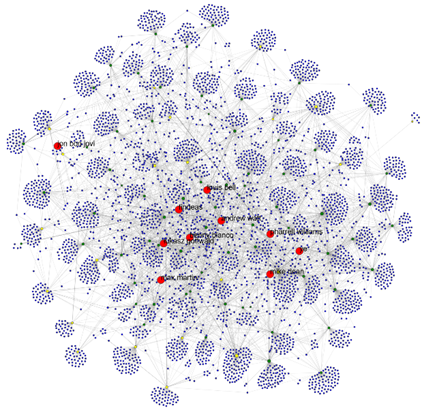

In [150]:
# Songwriters with the most links
top_songwriters

[('max martin', 106),
 ('benny blanco', 70),
 ('louis bell', 66),
 ('łukasz gottwald', 59),
 ('tyler joseph', 57),
 ('finneas', 53),
 ('jon bon jovi', 52),
 ('andrew watt', 46),
 ('mike dean', 46),
 ('jonny buckland', 45)]

#### Community detection

In [158]:
# Load the JSON file
with open("Songwriter_Artist_graph.json", "r") as f:
    data = json.load(f)

# Convert to NetworkX graph
G = json_graph.node_link_graph(data)

# Check edges
print(f"Initial nodes: {G.number_of_nodes()}")
print(f"Initial edges: {G.number_of_edges()}")

Initial nodes: 4584
Initial edges: 6635


In [ ]:
import community as community_louvain  # this is the python-louvain package

# Run Louvain on the song graph
partition = community_louvain.best_partition(G, weight='weight')

# Force all community IDs to int
partition = {node: int(group) for node, group in partition.items()}

In [153]:
nx.set_node_attributes(G, partition, name='group')

In [154]:
community_sizes = Counter(partition.values())

In [155]:
num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")

Number of communities: 36


In [ ]:
netwulf.visualize(G)

(None, None)

Result of community detection:

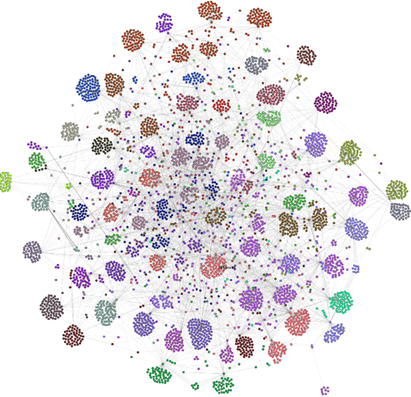

#### Reduced network

In [161]:
# Load the JSON file
with open("Songwriter_Artist_graph.json", "r") as f:
    data = json.load(f)

# Convert to NetworkX graph
G = json_graph.node_link_graph(data)

# Check edges
print(f"Initial nodes: {G.number_of_nodes()}")
print(f"Initial edges: {G.number_of_edges()}")

Initial nodes: 4584
Initial edges: 6635


In [162]:
# 1. Extract largest connected component
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

# 2. Compute strength (weighted degree)
strengths = dict(G_lcc.degree(weight='weight'))
nx.set_node_attributes(G_lcc, strengths, name='strength')
max_strength = max(strengths.values())

# 3. Normalize roles: lowercase, strip
for node in G_lcc.nodes:
    roles = G_lcc.nodes[node].get('role', [])
    if isinstance(roles, list):
        G_lcc.nodes[node]['role'] = [r.strip().lower() for r in roles]

# 4. Identify role groups
pure_songwriters = [
    node for node, data in G_lcc.nodes(data=True)
    if data.get('role') == ['songwriter']
]

pure_artists = [
    node for node, data in G_lcc.nodes(data=True)
    if data.get('role') == ['artist']
]

mixed_roles = [
    node for node, data in G_lcc.nodes(data=True)
    if isinstance(data.get('role'), list) and
       'artist' in data['role'] and 'songwriter' in data['role']
]

# 5. Top 10 pure songwriters by strength
top_songwriters = sorted(
    [(node, strengths[node]) for node in pure_songwriters],
    key=lambda x: x[1],
    reverse=True
)[:10]
top_songwriter_nodes = set(node for node, _ in top_songwriters)

# 6. Style nodes: color, size, label
for node in G_lcc.nodes:
    roles = G_lcc.nodes[node].get('role', [])
    strength = strengths.get(node, 1)
    base_size = 20 + (strength / max_strength) * 80

    if node in top_songwriter_nodes:
        G_lcc.nodes[node]['color'] = 'red'
        G_lcc.nodes[node]['size'] = 500
        G_lcc.nodes[node]['label'] = node
    elif node in pure_songwriters:
        G_lcc.nodes[node]['color'] = 'blue'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    elif node in pure_artists:
        G_lcc.nodes[node]['color'] = 'yellow'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    elif node in mixed_roles:
        G_lcc.nodes[node]['color'] = 'green'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""
    else:
        G_lcc.nodes[node]['color'] = 'gray'
        G_lcc.nodes[node]['size'] = base_size
        G_lcc.nodes[node]['label'] = ""


# # Find nodes with degree 1
nodes_to_remove = [node for node, degree in G_lcc.degree() if degree < 2 ]

# Remove them
G_lcc.remove_nodes_from(nodes_to_remove)

# 7. Visualize
netwulf.visualize(G_lcc)


(None, None)

Result of reduced network: 

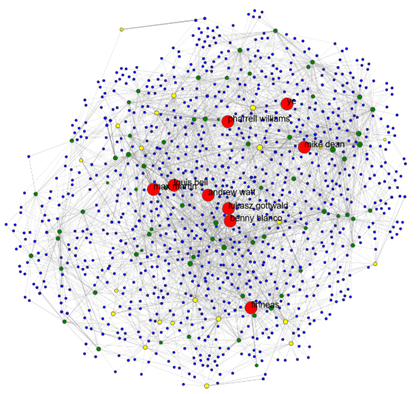

#### Community detection

In [165]:
# Load the JSON file
with open("Songwriter_Artist_graph.json", "r") as f:
    data = json.load(f)

# Convert to NetworkX graph
G = json_graph.node_link_graph(data)

# Check edges
print(f"Initial nodes: {G.number_of_nodes()}")
print(f"Initial edges: {G.number_of_edges()}")

# Debug: show low-degree nodes
low_degree_nodes = [n for n, d in G.degree() if d < 2]
print(f"Nodes with degree < 2: {len(low_degree_nodes)}")

# Remove them
G.remove_nodes_from(low_degree_nodes)

# Final count
print(f"Remaining nodes: {G.number_of_nodes()}")
print(f"Remaining edges: {G.number_of_edges()}")

Initial nodes: 4584
Initial edges: 6635
Nodes with degree < 2: 3515
Remaining nodes: 1069
Remaining edges: 3121


In [166]:
# Run Louvain on the song graph
partition = community_louvain.best_partition(G, weight='weight')

# Force all community IDs to int
partition = {node: int(group) for node, group in partition.items()}

In [167]:
nx.set_node_attributes(G, partition, name='group')
community_sizes = Counter(partition.values())

In [168]:
network, config = netwulf.visualize(G)

Result of community detection:

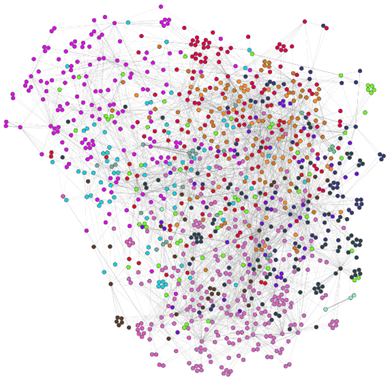

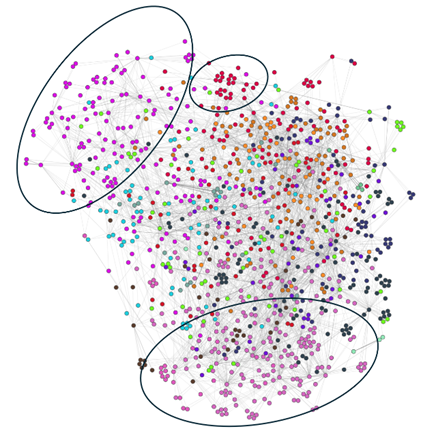 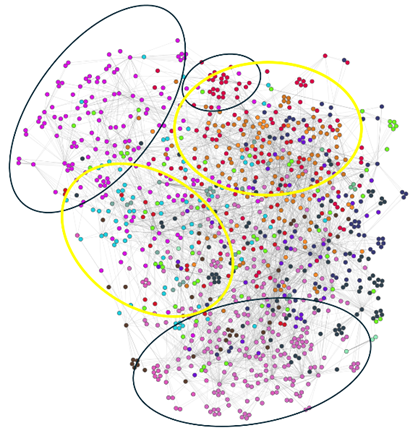

## Dataset analysis

## Semantic analysis - Lyrics

#### Talk about how you've worked with text, including regular expressions, unicode, etc.

When we first generated a word cloud, it didn’t reveal any significant patterns, so we decided to focus our analysis on individual artists and thematic topics instead.

In [ ]:
# Join all tokens for the WordCloud
all_text = " ".join(df["joined_tokens"])

# Generate and plot WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of most used words in all songs")
plt.show()


We selected Camila Cabello, Miley Cyrus, and Selena Gomez because they are among the most influential artists within a specific pop subgenre. Their prominence and commercial success make them representative figures for exploring the lyrical patterns and vocabulary commonly found in this part of the pop music landscape.

The purpose of this analysis is to investigate how language is used within the genre by comparing the artists’ lyrical styles. By applying TF-IDF (term frequency–inverse document frequency) to their lyrics, we can highlight the words that are most characteristic of each artist. This allows us to uncover the distinct themes, expressions, or stylistic choices that define their songwriting, and, more broadly, gain insight into the linguistic features that shape the genre as a whole.

In [36]:
# Join tokens to text per song
df["tokens"] = df["tokens"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else [])
df["joined_tokens"] = df["tokens"].apply(lambda x: " ".join(x))

# Compute TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["joined_tokens"])
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [ ]:
import warnings

# Too many warnings showed...
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


# Only keeping songs by the three artists we want to compare
target_artists = ['camila cabello', 'miley cyrus', 'selena gomez']
filtered_df = df[df['Artist'].str.lower().isin(target_artists)]

# Making sure the tokens are in one long string per song
filtered_df["joined_tokens"] = filtered_df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Putting all songs from each artist into one big string per artist
artist_df = filtered_df.groupby("Artist")["joined_tokens"].apply(" ".join).reset_index()

# Some words just keep popping up and don’t say much — removing them manually
custom_stopwords = set([
    'yeah', 'na', 'oh', 'uh', 'ha', 'got', 'wan', 'ca', 'know', 'let', 'say', 'hey',
    'get', 'make', 'gonna', 'im', 'ill', 'aint', 'dont', 'youre', 'ive', 'could', 'would'
])

# Going through and taking those words out before doing TF-IDF
artist_df["filtered_tokens"] = artist_df["joined_tokens"].apply(
    lambda x: " ".join([word for word in x.split() if word not in custom_stopwords])
)

# Using TF-IDF to see which words are most "special" to each artist
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(artist_df["filtered_tokens"])
feature_names = vectorizer.get_feature_names_out()

# Plotting top 10 words per artist based on their TF-IDF score
for i, artist in enumerate(artist_df["Artist"]):
    row = tfidf_matrix[i].toarray().flatten()
    top_indices = np.argsort(row)[-10:]
    top_words = [feature_names[j] for j in top_indices]
    top_scores = [row[j] for j in top_indices]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_scores, y=top_words, palette="crest")
    plt.title(f"Top TF-IDF Words for {artist.title()}")
    plt.xlabel("TF-IDF Score")
    plt.tight_layout()
    plt.show()


In [ ]:
# Define target artists (case-insensitive match)
target_artists = ['camila cabello', 'miley cyrus', 'selena gomez']
filtered_df = df[df['Artist'].str.lower().isin([a.lower() for a in target_artists])]

# Ensure joined_tokens exists (can be skipped if already present)
filtered_df["joined_tokens"] = filtered_df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Generate word clouds
for artist in target_artists:
    artist_rows = filtered_df[filtered_df['Artist'].str.lower() == artist]
    if artist_rows.empty:
        continue  # skip if artist has no songs
    text = " ".join(artist_rows["joined_tokens"])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(6, 3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud: {artist.title()}")
    plt.tight_layout()
    plt.show()


The same is done for Travis Scott, Cardi B, Nicki Minaj, Drake, Meek Mill

In [ ]:
# Too many warnings showed...
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


# Only keeping songs by the three artists we want to compare
target_artists = ['travis scott', 'cardi b', 'nicki minaj','drake', 'meek mill']
filtered_df = df[df['Artist'].str.lower().isin(target_artists)]

# Making sure the tokens are in one long string per song
filtered_df["joined_tokens"] = filtered_df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Putting all songs from each artist into one big string per artist
artist_df = filtered_df.groupby("Artist")["joined_tokens"].apply(" ".join).reset_index()

# Some words just keep popping up and don’t say much — removing them manually
custom_stopwords = set([
    'yeah', 'na', 'oh', 'uh', 'ha', 'got', 'wan', 'ca', 'know', 'let', 'say', 'hey',
    'get', 'make', 'gonna', 'im', 'ill', 'aint', 'dont', 'youre', 'ive', 'could', 'would'
])

# Going through and taking those words out before doing TF-IDF
artist_df["filtered_tokens"] = artist_df["joined_tokens"].apply(
    lambda x: " ".join([word for word in x.split() if word not in custom_stopwords])
)

# Using TF-IDF to see which words are most "special" to each artist
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(artist_df["filtered_tokens"])
feature_names = vectorizer.get_feature_names_out()

# Plotting top 10 words per artist based on their TF-IDF score
for i, artist in enumerate(artist_df["Artist"]):
    row = tfidf_matrix[i].toarray().flatten()
    top_indices = np.argsort(row)[-10:]
    top_words = [feature_names[j] for j in top_indices]
    top_scores = [row[j] for j in top_indices]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_scores, y=top_words, palette="crest")
    plt.title(f"Top TF-IDF Words for {artist.title()}")
    plt.xlabel("TF-IDF Score")
    plt.tight_layout()
    plt.show()


In [ ]:
# Define target artists (case-insensitive match)
target_artists = ['travis scott', 'cardi b', 'nicki minaj', 'drake', 'meek mill']
filtered_df = df[df['Artist'].str.lower().isin([a.lower() for a in target_artists])]

# Ensure joined_tokens exists (can be skipped if already present)
filtered_df["joined_tokens"] = filtered_df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Generate word clouds
for artist in target_artists:
    artist_rows = filtered_df[filtered_df['Artist'].str.lower() == artist]
    if artist_rows.empty:
        continue  # skip if artist has no songs
    text = " ".join(artist_rows["joined_tokens"])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(6, 3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud: {artist.title()}")
    plt.tight_layout()
    plt.show()


In [ ]:
# Defining artist groups
pop_artists = ['camila cabello', 'miley cyrus', 'selena gomez']
rap_artists = ['travis scott', 'cardi b', 'nicki minaj', 'drake', 'meek mill']

# Make sure tokens are joined
df["joined_tokens"] = df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Combine lyrics by group
group_texts = {
    "Pop": " ".join(df[df['Artist'].str.lower().isin(pop_artists)]["joined_tokens"]),
    "Rap": " ".join(df[df['Artist'].str.lower().isin(rap_artists)]["joined_tokens"]),
}

# Compute TF-IDF
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(group_texts.values())
feature_names = vectorizer.get_feature_names_out()

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=group_texts.keys(), columns=feature_names)

# Get top N terms per group (or union of top N from both)
top_n = 20
top_pop = tfidf_df.loc["Pop"].sort_values(ascending=False).head(top_n)
top_rap = tfidf_df.loc["Rap"].sort_values(ascending=False).head(top_n)
top_words = list(set(top_pop.index).union(set(top_rap.index)))

# Filter DataFrame to these words
heatmap_df = tfidf_df[top_words]

# Plot heatmap
plt.figure(figsize=(15, 3))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", cbar_kws={"label": "TF-IDF Score"})
plt.title("TF-IDF Word Comparison: Pop vs Rap Artists")
plt.xlabel("Top Words")
plt.ylabel("Artist Group")
plt.tight_layout()
plt.show()


In [ ]:
# Just keeping things quiet
warnings.simplefilter(action='ignore', category=FutureWarning)

# Some words just keep popping up and don’t say much — removing them manually
custom_stopwords = set([
    'yeah', 'na', 'oh', 'uh', 'ha', 'got', 'wan', 'ca', 'know', 'let', 'say', 'hey',
    'get', 'make', 'gonna', 'im', 'ill', 'aint', 'dont', 'youre', 'ive', 'could', 'would'
])

# Making sure the tokens are joined (if not already)
df["joined_tokens"] = df["tokens"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Remove custom stopwords from the joined lyrics
df["filtered_lyrics"] = df["joined_tokens"].apply(
    lambda x: " ".join([word for word in x.split() if word not in custom_stopwords])
)

# TF-IDF vectorization (per song, after removing common junk words)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf = vectorizer.fit_transform(df["filtered_lyrics"])

# Applying NMF to find common themes in the lyrics
nmf = NMF(n_components=5, random_state=42)
nmf_features = nmf.fit_transform(tfidf)

# Extract the top 10 words per topic
feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_weights in nmf.components_:
    top_words = [feature_names[i] for i in topic_weights.argsort()[-10:][::-1]]
    topics.append(top_words)

# Assign each song to the topic it most strongly relates to
df['Topic'] = nmf_features.argmax(axis=1)
df['Topic Label'] = df['Topic'].apply(lambda x: f"Topic {x+1}: " + ", ".join(topics[x][:3]))

# Visualizing how many songs belong to each topic
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Topic Label', order=df['Topic Label'].value_counts().index, palette="cool")
plt.title("Thematic Topics Across Songs")
plt.tight_layout()
plt.show()


--------------------------------

# Discussion

#### What went well?


#### What is still missing? What could be improved? Why?